In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import shutil,random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import optuna

s:\vscode\Machine Learning\.venv\lib\site-packages\google\api_core\_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


### Adding paths to retreive data

In [2]:
base_dir = r"S:\vscode\Machine Learning\Tensorflow_basics\cats_vs_dogs\cats_and_dogs_filtered"

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

### Creating new dir for test

In [3]:
test_dir=os.path.join(base_dir,'test')
test_cats_dir=os.path.join(test_dir,'cats')
test_dogs_dir=os.path.join(test_dir,'dogs')

os.makedirs(test_cats_dir,exist_ok=True)
os.makedirs(test_dogs_dir,exist_ok=True)

### Helper function to split data in 50 %

In [4]:
# Helper function to shuffle and slipt the validation(any data) into 0.5 = 50% and move to new dir 
def create_test_split(source_dir,destination_dir,split_ratio=0.5):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_size = int(len(files)*split_ratio)
    test_file = files[:split_size]
    for f in test_file:
        shutil.move(os.path.join(source_dir,f),os.path.join(destination_dir,f))


### Spliting the validation dir and moving the files to Test dir

In [5]:
create_test_split(os.path.join(validation_dir,'cats'),test_cats_dir,split_ratio=0.5)
create_test_split(os.path.join(validation_dir,'dogs'),test_dogs_dir,split_ratio=0.5)

### Number of images in dir

In [34]:
data_dirs = [train_dir,validation_dir,test_dir]
sub_dirs= ['cats','dogs']
for d in data_dirs:
    for s in sub_dirs:
        folder = os.path.join(d,s)
        count=len(os.listdir(folder))
        short_path = os.path.basename(d)+'/'+s
        print(f"No. of images in {short_path} :{count}" )

No. of images in train/cats :1000
No. of images in train/dogs :1000
No. of images in validation/cats :250
No. of images in validation/dogs :250
No. of images in test/cats :250
No. of images in test/dogs :250


### Creating the datasets


In [35]:
IMAGE_SIZE =(150,150)
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


### Normalization data 
Converting it to a scale between 0 to 1

In [36]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
val_ds=val_ds.map(lambda x,y:(normalization_layer(x),y))
test_ds=test_ds.map(lambda x,y:(normalization_layer(x),y))

### Augumenting the Data 
Adding the rotation, flips, zoom to avoid overfitting

In [37]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

### Model

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'), # reduce the nodes
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

### Compile

In [39]:
lr = 0.0005

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Train

In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs =10,
    verbose =1
    )

Epoch 1/10
32/32 [==============================] - 41s 1s/step - loss: 0.7014 - accuracy: 0.5000 - val_loss: 0.6882 - val_accuracy: 0.5200
Epoch 2/10
32/32 [==============================] - 39s 1s/step - loss: 0.6810 - accuracy: 0.5630 - val_loss: 0.6501 - val_accuracy: 0.6600
Epoch 3/10
32/32 [==============================] - 71s 2s/step - loss: 0.6469 - accuracy: 0.6380 - val_loss: 0.6425 - val_accuracy: 0.6260
Epoch 4/10
32/32 [==============================] - 40s 1s/step - loss: 0.6329 - accuracy: 0.6620 - val_loss: 0.6445 - val_accuracy: 0.6320
Epoch 5/10
32/32 [==============================] - 39s 1s/step - loss: 0.5870 - accuracy: 0.6965 - val_loss: 0.6516 - val_accuracy: 0.6140
Epoch 6/10
32/32 [==============================] - 40s 1s/step - loss: 0.5589 - accuracy: 0.7110 - val_loss: 0.6482 - val_accuracy: 0.6340
Epoch 7/10
32/32 [==============================] - 40s 1s/step - loss: 0.5134 - accuracy: 0.7500 - val_loss: 0.6251 - val_accuracy: 0.6540
Epoch 8/10
32/32 [==

### Predicting a image from test dir 

In [42]:
img_path = test_dir + "/dogs/dog.2029.jpg"

img = tf.keras.utils.load_img(img_path,target_size=IMAGE_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array,0)

#normalizing
img_array=img_array/255.0

pred = model.predict(img_array)
print("Model Predicted : ",pred)

1/1 [==============================] - 0s 68ms/step
Model Predicted :  [[0.8065989]]


In [43]:
if pred[0][0]>0.5:
    print("Predicted Dog")
else:
    print("Predicted Cat")

Predicted Dog


Text(0.5, 1.0, 'Prediction : Dog')

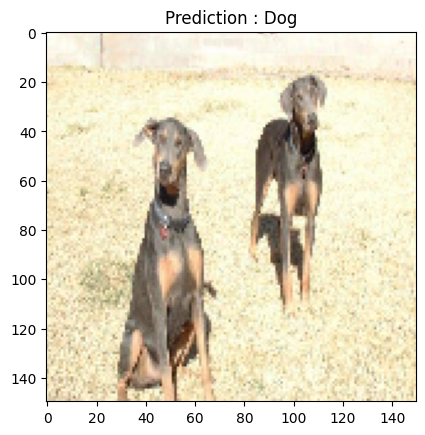

In [44]:
plt.imshow(img)
plt.title("Prediction : Dog" if pred[0][0]>0.5 else "Prediction : Cat")

### Evaluating the entire dataset

In [45]:
loss,acc  =model.evaluate(test_ds)
print("Test Loss:",loss)
print("Test accuracy:",acc)

8/8 [==============================] - 4s 249ms/step - loss: 0.6622 - accuracy: 0.6520
Test Loss: 0.6622381806373596
Test accuracy: 0.6520000100135803


In [46]:
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32")

8/8 [==============================] - 2s 232ms/step


In [47]:
# Get true labels from test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32")

# Confusion Matrix
print(confusion_matrix(true_labels, predicted_labels))

# Classification Report
print(classification_report(true_labels, predicted_labels, target_names=['Cat','Dog']))

8/8 [==============================] - 2s 240ms/step
[[ 94 156]
 [104 146]]
              precision    recall  f1-score   support

         Cat       0.47      0.38      0.42       250
         Dog       0.48      0.58      0.53       250

    accuracy                           0.48       500
   macro avg       0.48      0.48      0.47       500
weighted avg       0.48      0.48      0.47       500



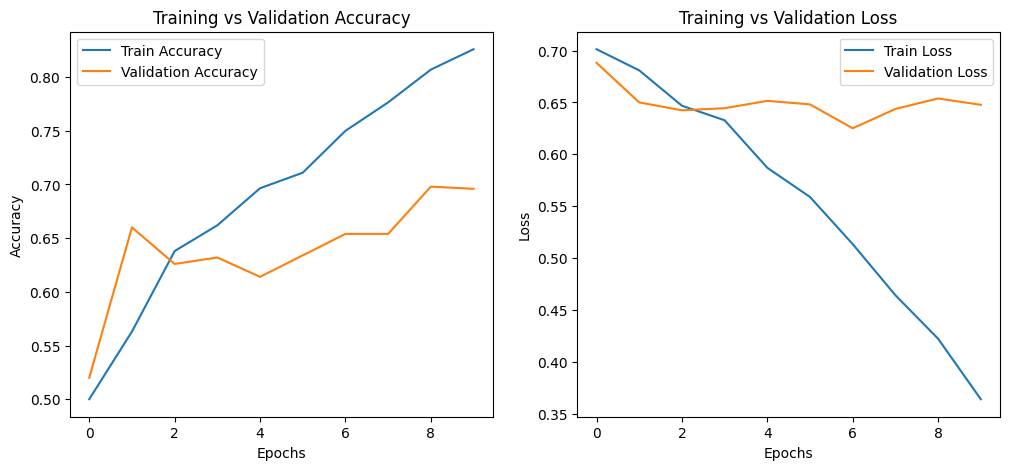

In [48]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Tuning model with OPTUNA to increase the Accuracy and reduce the Loss 

1. trail.suggest_int(name, low, high, step) - suggest a integer value in a range
2. trail.suggest_uniform(name, low, high) - suggests a float value in a range 
3. trail.suggest_loguniform(name, low, high) - suggests a float on a log scale , good for learning rate
4. trail.suggests_categorial(name, choice) - suggest one value in the choice

In [69]:
def objective(trial):
    # hyperparameters

    lr = trial.suggest_float('learning_rate',1e-5,1e-2, log=True)
    nodes = trial.suggest_int('nodes',32,256 ,step=32)
    batch_size = trial.suggest_categorical('batch_size',[32,64]) 
    dropout = trial.suggest_float('dropout',0.2,0.6)
    epochs = trial.suggest_int('epochs',5,15)

    #model
    model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32,(3,3),activation='relu', input_shape= (150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(nodes,activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1,activation='sigmoid')

    ]) 

    #compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    #load dataset
    #again loading because we might vary the batch_size as per optuna
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,image_size=(150,150),batch_size=batch_size) 

    val_ds = tf.keras.utils.image_dataset_from_directory(
        validation_dir,image_size=(150,150),batch_size=batch_size)

    #normalization
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x,y : (normalization_layer(x),y))
    val_ds = val_ds.map(lambda x,y : (normalization_layer(x),y))

    #train
    history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=0)

    #metrics
    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_accuracy'])
    
    trial.set_user_attr("val_accuracy",val_acc)

    return val_loss



In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)

In [ ]:
print(f"Best trail:{study.best_trial}")
print(f"Best val_loss:{study.best_trial}")